In [2]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0    # 입력 이미지는 항상 깊이 차원이 있어야, Conv2D 층 사용 위해 추가
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)

4431872/4422102 [==============================] - 0s 0us/step


In [3]:
model = keras.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=(28,28,1)))
model.add(keras.layers.MaxPooling2D(2))
model.add(keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D(2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu'))    # 일렬로 펼치고 바로 전달하지 않고 중간에 밀집 은닉층 추가
model.add(keras.layers.Dropout(0.4))    # 드롭아웃으로 앙상블 효과
model.add(keras.layers.Dense(10, activation='softmax'))

In [4]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
history = model.fit(train_scaled, train_target, epochs=20,
                    validation_data = (val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
1500/1500 [==============================] - 70s 46ms/step - loss: 0.5386 - accuracy: 0.8050 - val_loss: 0.3419 - val_accuracy: 0.8737
Epoch 2/20
1500/1500 [==============================] - 72s 48ms/step - loss: 0.3565 - accuracy: 0.8730 - val_loss: 0.2845 - val_accuracy: 0.8916
Epoch 3/20
1500/1500 [==============================] - 65s 43ms/step - loss: 0.3059 - accuracy: 0.8891 - val_loss: 0.2559 - val_accuracy: 0.9041
Epoch 4/20
1500/1500 [==============================] - 73s 48ms/step - loss: 0.2744 - accuracy: 0.8997 - val_loss: 0.2477 - val_accuracy: 0.9079
Epoch 5/20
1500/1500 [==============================] - 70s 47ms/step - loss: 0.2500 - accuracy: 0.9081 - val_loss: 0.2416 - val_accuracy: 0.9102
Epoch 6/20
1500/1500 [==============================] - 63s 42ms/step - loss: 0.2283 - accuracy: 0.9149 - val_loss: 0.2281 - val_accuracy: 0.9139
Epoch 7/20
1500/1500 [==============================] - 84s 56ms/step - loss: 0.2128 - accuracy: 0.9209 - val_loss: 0.2236 -

In [5]:
model = keras.models.load_model('best-cnn-model.h5')
model.layers

In [6]:
conv = model.layers[0]
print(conv.weights[0].shape, conv.weights[1].shape)    # 가중치 크기, 절편

(3, 3, 1, 32) (32,)


In [7]:
conv_weights = conv.weights[0].numpy()

In [8]:
print(conv_weights.mean(), conv_weights.std())    # 가중치 배열의 평균과 표준편차

-0.024579149 0.2507598


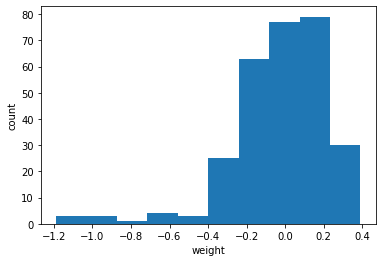

In [9]:
import matplotlib.pyplot as plt
plt.hist(conv_weights.reshape(-1, 1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

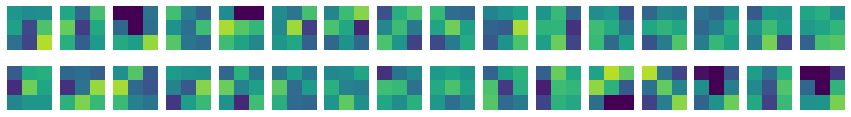

In [10]:
fig, axs = plt.subplots(2, 16, figsize=(15,2))
for i in range(2):
  for j in range(16):
    axs[i, j].imshow(conv_weights[:,:,0,i*16 + j], vmin=-0.5, vmax=0.5)
    axs[i, j].axis('off')
plt.show()

In [11]:
# 빈 합성곱 신경망
no_training_model = keras.Sequential()
no_training_model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=(28,28,1)))

In [12]:
no_training_conv = no_training_model.layers[0]
print(no_training_conv.weights[0].shape)

(3, 3, 1, 32)


In [13]:
no_training_weights = no_training_model.weights[0].numpy()
print(no_training_weights.mean(), no_training_weights.std())

-0.0023361398 0.08756672


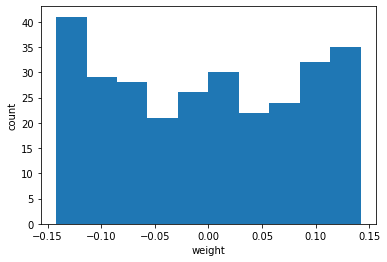

In [14]:
plt.hist(no_training_weights.reshape(-1, 1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

In [15]:
# 훈련되지 않은 모델의 가중치가 이러한 이유는 텐서플로가 신경망의 가중치를 처음 초기화할 때 균등 분포에서 랜덤하게 값을 선택하기 때문

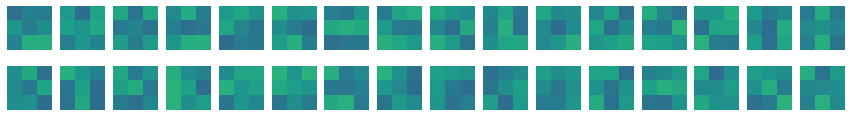

In [16]:
fig, axs = plt.subplots(2, 16, figsize=(15,2))
for i in range(2):
  for j in range(16):
    axs[i, j].imshow(no_training_weights[:,:,0,i*16 + j], vmin=-0.5, vmax=0.5)
    axs[i, j].axis('off')
plt.show()

In [17]:
print(model.input)

KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='conv2d_input'), name='conv2d_input', description="created by layer 'conv2d_input'")


In [18]:
conv_acti = keras.Model(model.input, model.layers[0].output)

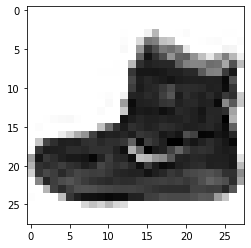

In [19]:
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
plt.imshow(train_input[0], cmap='gray_r')
plt.show()

In [21]:
# 특성 맵 출력
inputs = train_input[0:1].reshape(-1, 28, 28, 1) / 255.0
feature_maps = conv_acti.predict(inputs)

In [22]:
print(feature_maps.shape)

(1, 28, 28, 32)


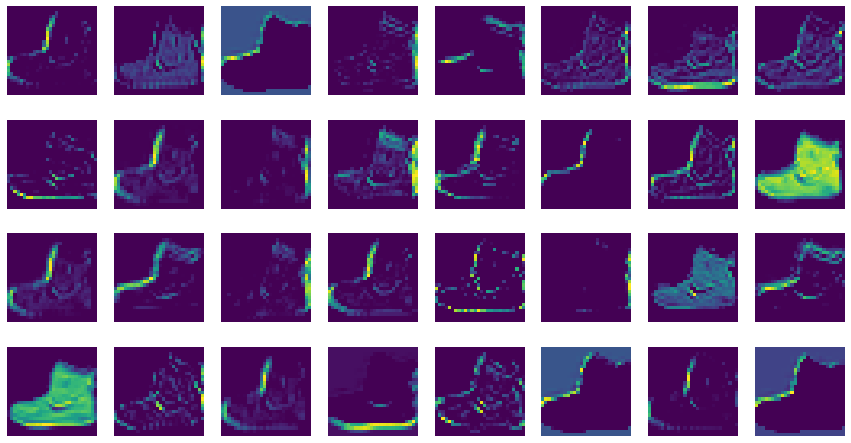

In [23]:
fig, axs = plt.subplots(4, 8, figsize=(15, 8))
for i in range(4):
  for j in range(8):
    axs[i, j].imshow(feature_maps[0,:,:,i*8+j])
    axs[i, j].axis('off')
plt.show()

In [24]:
conv2_acti = keras.Model(model.input, model.layers[2].output)

In [26]:
inputs = train_input[0:1].reshape(1, 28, 28, 1) / 255.0
feature_maps = conv2_acti.predict(inputs)

In [27]:
print(feature_maps.shape)

(1, 14, 14, 64)


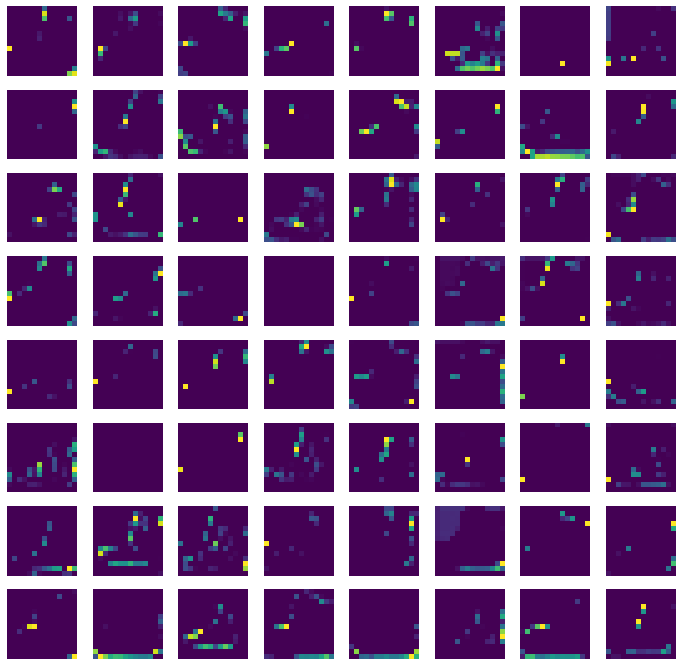

In [28]:
fig, axs = plt.subplots(8, 8, figsize=(12, 12))
for i in range(8):
  for j in range(8):
    axs[i, j].imshow(feature_maps[0,:,:,i*8+j])
    axs[i, j].axis('off')
plt.show()